# Un modelo para detección de fraudes en transacciones financieras.



Para mi una de las aplicaciones más interesantes y útiles en la práctica del ML es la detección de fraudes en transacciones financieras, un campo de acción que puede ser manejado desde el enfoque de modelos de clasificación o también desde el análisis de anomalías. 

En general explorar y experimentar en la creación de modelos de ML para detección de fraudes, se hace un poco más complejo por la falta de set de datos disponibles públicamente, lo cual es entendible ya que pocas entidades financieras están dispuestos a poner información financiera y operativa potencialmente sensible en el dominio público.

El objetivo de este notebook exponer una aproximación sencilla al problema de la la detección de fraudes, que espero le pueda servir a alguien ya sea como una referencia inicial en el problema de detección de fraudes, o quizá como  punto de arranque para la creación de modelos más complejos. 

El set datos usado en este proyecto es un dataset sintético creado por PaySim quien ha generado partir de transacciones reales privadas de un servicio de dinero móvil implementado en un país africano, un set de datos sintético que simula una operación transaccional normal a la cual se ha inyectado comportamiento malicioso para luego evaluar el desempeño de modelos de detección de fraudes.. El set de datos original se encuentra disponible en la plataforma Kaggle (https://www.kaggle.com/ntnu-testimon/paysim1)


In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,roc_auc_score, roc_curve, f1_score

## Data exploration

Iniciemos explorando los datos para tener un entendimiento de la información con datos clave como el tamaño del dataset, columnas, datos faltantes, outliers, etc.

In [3]:
# read in the json files
transactions_df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

transactions_df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
transactions_df.shape

(6362620, 11)

El set de datos es moderadamente grande con:

    6362620 Filas 
    11      Columnas
    

In [5]:
transactions_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

#### Definición de las columnas del dataset (copiado desde Kaggle)

**step**     - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type**     - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount**   - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg**  - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest**       - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud**        - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Tipo de transacciones

In [213]:
transactions_df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [214]:
transactions_df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

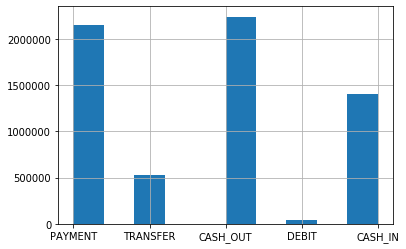

In [215]:
transactions_df['type'].hist()

In [217]:
transactions_df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

No existen valores nulos o faltantes dentro del dataset

### Cuantos fraudes tenemos?

In [218]:
transactions_df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

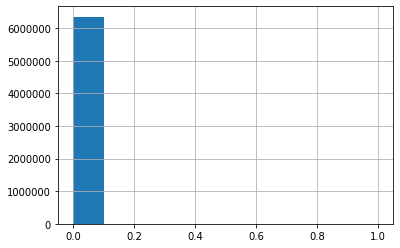

In [219]:
transactions_df['isFraud'].hist()


Solo **8213** filas de un total de algo más de **6 Millones** reprentan fraudes ( solo un **0.13%** ! ), lo cual era casi de esperar ya que por lo general en un set de datos financieros el número de fraudes registrados es casi siempre muy pequeño comparado con el número total de transacciones.

Este desbalance de clases (Los fraudes representan solo el 0.13% del total) debe ser manejado de alguna manera y es crucial para luego escoger el algoritmo de clasificación de nuestro modelo.

Veamos ahora cuantos fraudes hay por tipo de transaccion:

In [220]:
transactions_df.groupby(['type','isFraud'])['isFraud'].count()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: isFraud, dtype: int64

De acuerdo a los datos, los fraudes se han presentado solamente en las transacciones tipo **CASH_OUT** y **TRANSFER**

#### Distribucion del monto de las transacciones ( Columna amount)

In [221]:
transactions_df['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [25]:
q25  = np.quantile(transactions_df['amount'], 0.25)
q75  = round( np.quantile(transactions_df['amount'], 0.75) , 2 )
rmax = round( np.max(transactions_df['amount']) , 2 )
rmin = round( np.min(transactions_df['amount']) , 2 )

print("min=" + str(rmin) + " , 25%=" + str(q25) + " , 75%=" + str(q75) + " , max=" + str(rmax) )


min=0.0 , 25%=13389.57 , 75%=208721.48 , max=92445516.64


Grafiquemos ahora histogramas del monto de la transacciones por tipo de transaccion (type), intentando identificar algún patrón en los datos.

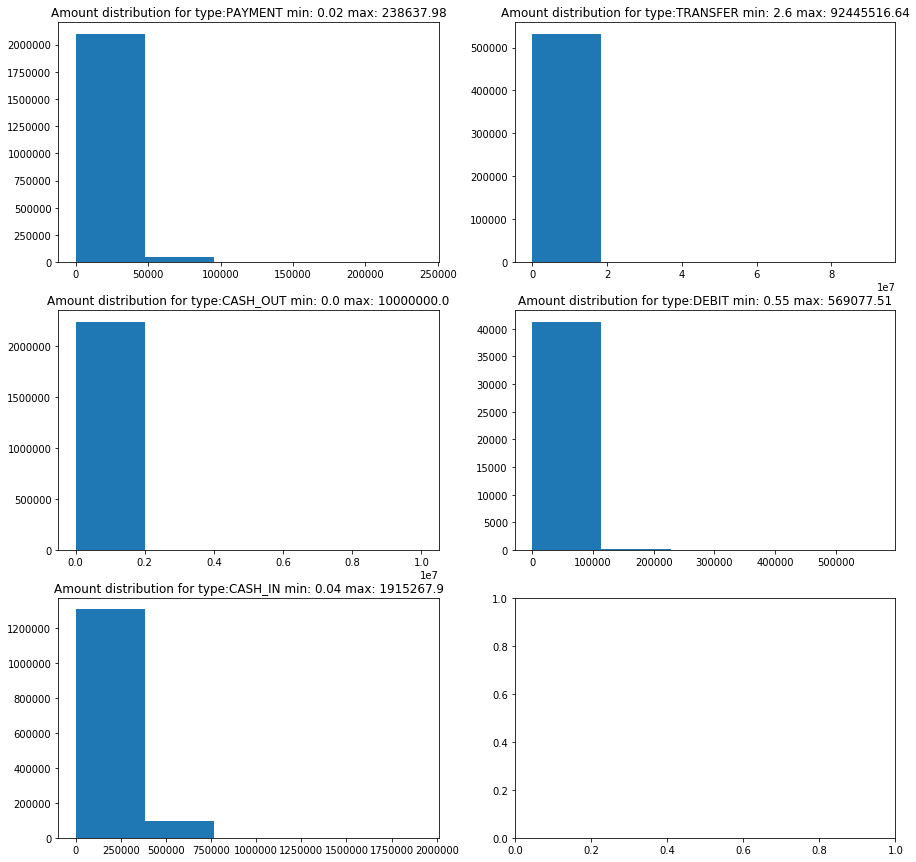

In [15]:

def plot_amount(interquartile=False):
    
    types = transactions_df['type'].unique()
    cols = 2
    nrows = int(len(types)/cols)+1

    _, axs = plt.subplots(nrows, cols, figsize=(15, 15))
    axs = axs.flatten()
    range=None

    for type, ax in zip(types, axs):
        df = transactions_df.loc[transactions_df['type']==type]
        q25  = np.quantile(df['amount'], 0.25)
        q75  = np.quantile(df['amount'], 0.75) 
        rmin = np.min(df['amount'])
        rmax = np.max(df['amount'])
        if (interquartile):
            range = (q25,q75)
        ax.hist(df['amount'] ,bins=5,histtype='bar',range=range)
        if (interquartile):
            ax.set_title('Amount distribution for type:' + type + " - range " + str(round(q25,2)) + " to " + str(round(q75,2)) )
        else:
            ax.set_title('Amount distribution for type:' + type + " min: " + str(round(rmin,2)) + " max: " + str(round(rmax,2)))

    plt.show()  
    
plot_amount()    

Los histogramas anteriores muestran que para todos los casos los datos se encuentran concentrados a la izquierda con outliers muy marcados en los tipos de transaccion **CASH_OUT** y **TRANSFER**, precisamente los tipos de transacciones donde tenemos fraudes. Veamos si al graficar el rango interquartil del 25 al 75% podemos ver algo más interesante.


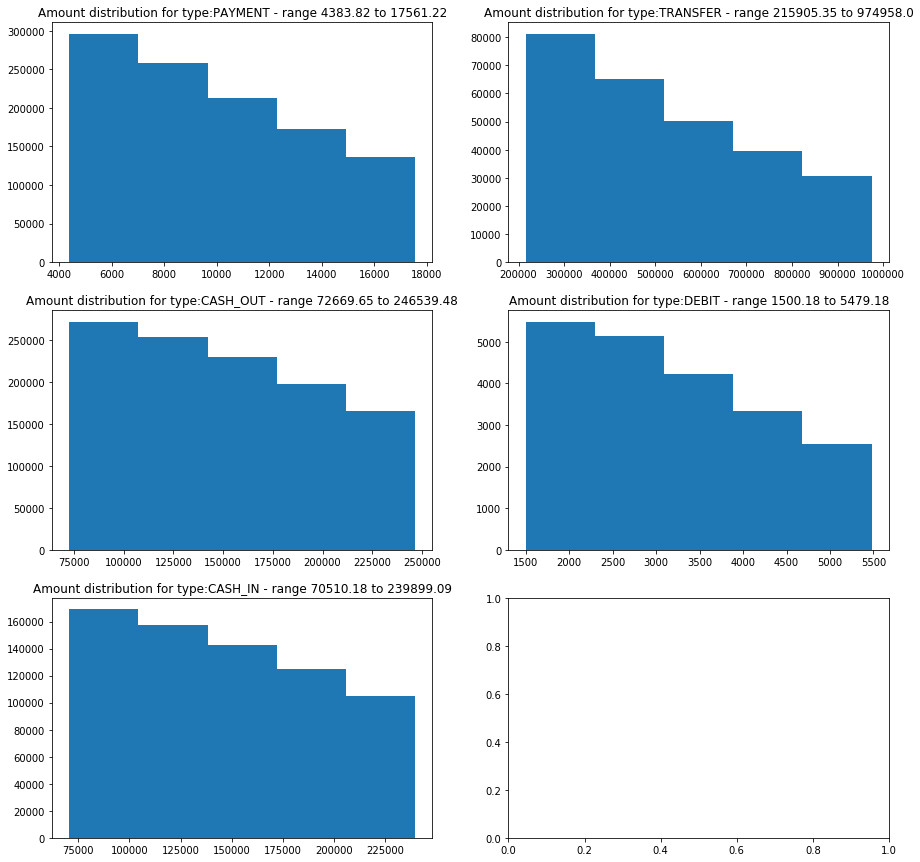

In [11]:
plot_amount(True) 


Grafiquemos ahora la distribución del monto en las transacciones fraudulentas

In [28]:
frauds = transactions_df['amount'].loc[transactions_df['isFraud']==1.0]
frauds.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [29]:

q25  = np.quantile(frauds, 0.25)
q75  = round( np.quantile(frauds, 0.75) , 2 )
rmax = round( np.max(frauds) , 2 )
rmin = round( np.min(frauds) , 2 )

print("min=" + str(rmin) + " , 25%=" + str(q25) + " , 75%=" + str(q75) + " , max=" + str(rmax) )



min=0.0 , 25%=127091.33 , 75%=1517771.48 , max=10000000.0


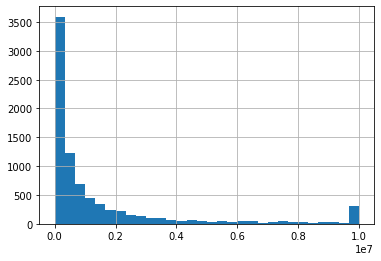

In [30]:
frauds.hist(bins=30,histtype='bar')

El histograma de los fraudes muestra igualmente que los datos se encuentran concentrados a la izquierda (asimetría postivia) y  outliers en 10M

In [91]:
transactions_num_df = transactions_df[[ 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
        'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']].copy()

## Feature Engineering

Antes es necesario hacer una conversión de la columna type, la cual es categorica, con los valores ('PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN')

Para la columna **type** se podría considerar  en una representación ordinal como 1 = PAYMENT, 2 = TRANSFER, 3 = CASH_OUT y asi en adelante. Sin embargo esto podría hacer que el modelo aprendiera que PAYMENT y TRANSFER son más similares que DEBIT y CASH_IN, ya que en realidad no hay una relación ordinal entre ellos. Por lo cual es nejor hacer una codificación tipo One Hot Encoding.

In [38]:
#one hot encode type
enc = OneHotEncoder(handle_unknown='ignore')
enc_type = pd.DataFrame(enc.fit_transform(  pd.DataFrame(transactions_num_df['type'])  ).toarray())

feature_labels = enc.categories_
feature_labels = np.array(feature_labels).ravel()
enc_type.columns = feature_labels

transactions_num_df = transactions_num_df.join(enc_type)

scaler = preprocessing.MinMaxScaler()
#amount oldbalanceOrg newbalanceOrig oldbalanceDest newbalanceDest
transactions_num_df['amount'] = scaler.fit_transform(transactions_num_df[['amount']])
transactions_num_df['oldbalanceOrg']     = scaler.fit_transform(transactions_num_df[['oldbalanceOrg']])
transactions_num_df['newbalanceOrig']    = scaler.fit_transform(transactions_num_df[['newbalanceOrig']])
transactions_num_df['oldbalanceDest']    = scaler.fit_transform(transactions_num_df[['oldbalanceDest']])
transactions_num_df['newbalanceDest']    = scaler.fit_transform(transactions_num_df[['newbalanceDest']])



### Correlación de las variables

Veamos ahora la correlación de todas las columnas del dataset con respecto al label (**isFraud**), que es valor que al final nuestro modelo debe ser capaz de predecir de con un buen nivel de confianza.

In [39]:
correlation_matrix = transactions_num_df.corr()
correlation_matrix['isFraud'].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
TRANSFER          0.053869
isFlaggedFraud    0.044109
CASH_OUT          0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
DEBIT            -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
CASH_IN          -0.019089
PAYMENT          -0.025697
Name: isFraud, dtype: float64

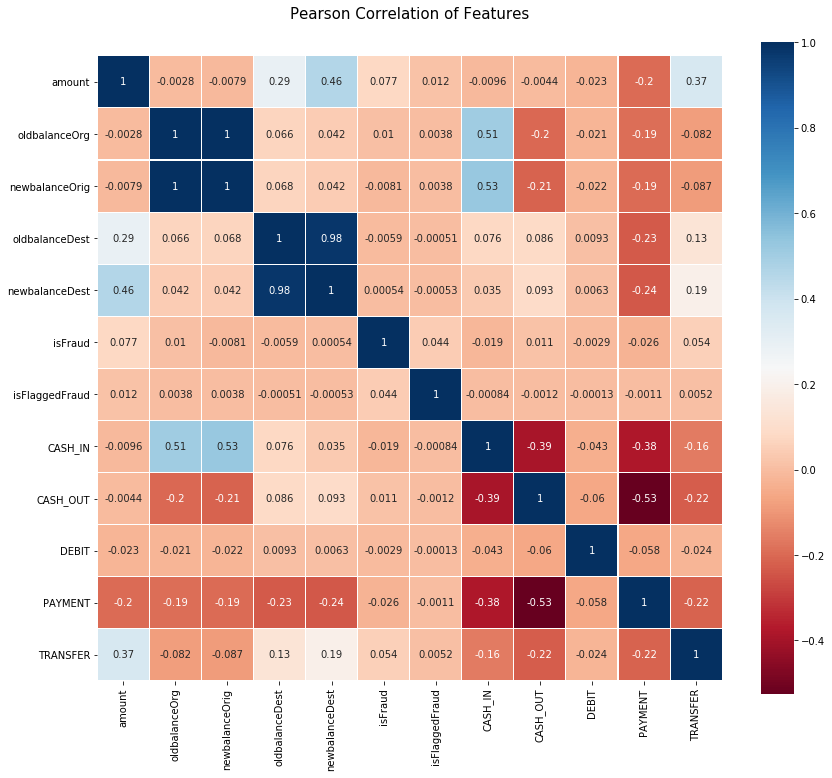

In [40]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_matrix,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Podemos observar que las columnas que más se correlacionan al label isFraud son:

De forma positiva: **amount, TRANSFER, isFlaggedFraud, CASH_OUT, oldbalanceOrg**   
De forma negativa: **PAYMENT y CASH_IN** (precisamente no hay fraudes para este tipo de transacciones)

### Seleccion de datos para entrenamiento y pruebas

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1 , test_size=0.2, random_state= 42 )


for train_index, test_index in split.split(transactions_num_df,transactions_num_df['type']):
    strat_train_set = transactions_num_df.iloc[train_index]
    strat_test_set  = transactions_num_df.iloc[test_index]

In [44]:
strat_train_set['type'].value_counts()/len(strat_train_set)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

In [45]:
strat_test_set['type'].value_counts()/len(strat_test_set)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006511
Name: type, dtype: float64

In [46]:
X_train = strat_train_set.drop(columns=['isFraud','type'])
y_train = strat_train_set['isFraud']
print(X_train.shape)
print(y_train.shape)
X_train.columns

(5090096, 11)
(5090096,)


Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'CASH_IN', 'CASH_OUT', 'DEBIT',
       'PAYMENT', 'TRANSFER'],
      dtype='object')

In [47]:
X_test = strat_test_set.drop(columns=['isFraud','type'])
y_test = strat_test_set['isFraud']
print(X_test.shape)
print(y_test.shape)
X_test.columns

(1272524, 11)
(1272524,)


Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'CASH_IN', 'CASH_OUT', 'DEBIT',
       'PAYMENT', 'TRANSFER'],
      dtype='object')

# Fase de selección y entrenamiento del modelo

Iniciaremos creando un modelo basado en el algoritmo Random Forest, el cual es un algoritmo flexible y fácil de usar que produce buenos resultados incluso sin ajustar los hiperparámetros. Queríamos usar este algoritmo también porque es útil para manejar grandes conjuntos de datos con una gran dimensionalidad, aunque este set de datos en particular no es tan grande.

In [48]:
seed = 42

rf = RandomForestClassifier(n_estimators = 100, random_state = seed)

rf.fit(X_train, y_train)

# Predict on training set
train_pred = rf.predict(X_train)

print( "RandomForestClassifier Accuracy: " + str( round( accuracy_score( y_train,train_pred)*100,2)) )
 
# How many classes are our model predicting?
print( np.unique( train_pred ) )

RandomForestClassifier Accuracy: 99.99
[0 1]


Wow, un Accuracy del **99.99%!** no tan rápido! no nos dejemos llevar por este valor. Recordemos que el total de filas con fraudes en el dataset representa **SOLO** el **0.13%** del total, por lo cual un Accuracy del **99.99%** solo nos puede estar diciendo que nuestro modelo es excelente para predecir transacciones **NO fraudulentas** :) 

Para los modelos de clasificación existen métricas más adecuadas para evaluar el desempeño, entre ellas la matriz de confusión y la precision y recall. Que básicamente lo que nos dice con respecto a la **precisión** es cuando nuestro modelo predice un fraude con que procentaje de precisión lo hace y con respecto al **recall/sentitividad/exhaustividad** se refiere a que porcentaje de fraudes del total es nuestro modelo capaz de identificar.

In [49]:
tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
(tn, fp, fn, tp )

(5083530, 0, 549, 6017)

In [51]:
precision = tp / (tp + fp)
recall =  tp / (tp + fn)

print("precision = {p} recall = {r}".format(p=round(precision*100,2),r=round(recall*100,2)) )

precision = 100.0 recall = 91.64


Los resultados siguen siendo muy buenos! tenemos una precisión del 100% y un recall de 91.64%! 

Es decir nuestro modelo es capaz de reconocer el 99,98% de los fraudes y cuando predice un fraude lo hace con un 100% de seguridad!

Sin embargo, debemos ser cautos y asegurar que estas metricas no sean porque nuestro modelo este haciendo overfit de los datos de entrenamiento...

### Cross validation

Para asegurar que el desempeño del modelo es tan bueno como lo dicen las métricas anteriores, implementemos un mecanismo llamado validación cruzada (Cross Validation) con el que básicamente lo que se hace es dividir el set de datos de entrenamiento en **k** bloques (folds) de datos más pequeños, y con cada uno de estos se hace lo siguiente:

El modelo se entrena utilizando **k-1** bloques del set de datos de entrenamiento.
    
El modelo resultante se valida con el bloque o fold restante que no ha sido visto por el modelo, usando una métrica predefinida (en este caso F1).  

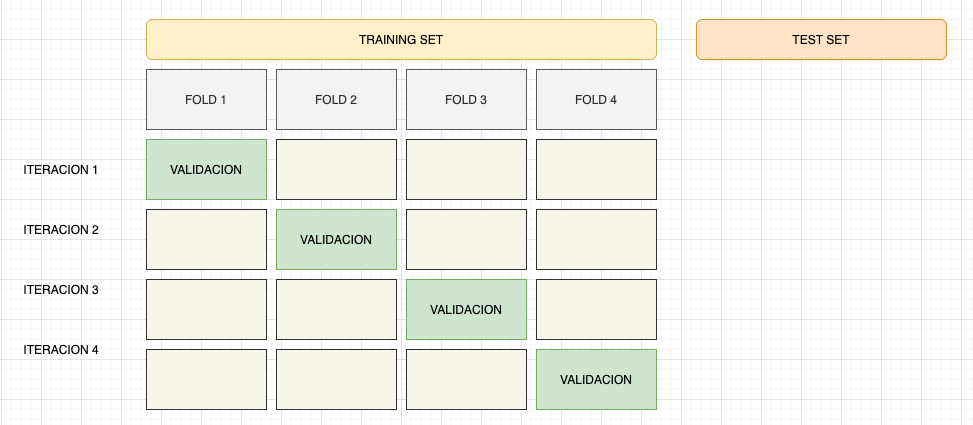

F1 que es una métrica calculada a partir de la precisión y la exhaustividad(recall), básicamente un F1 alto indica que tanto la precisión como el recall son ambos altos. La validación cruzada es una operación computacionalmente costosa, por lo tanto hay que estar preparados para esperar un buen rato...

In [58]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train, y_train, cv=4,scoring='f1')

In [59]:
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.85 F1 with a standard deviation of 0.01


Con los resultados de la validación cruzada podemos notar que el desempeño del modelo ya no es tán fantastico como inicialmente habiamos pensado. Anteriormente la precision era del 100% y el recall del 99%, ahora podemos notar que el F1 es el promedio del **85%**, un valor que sin embargo no es tán malo, al contrario muy bueno para tener un modelo con el que iniciar.

## Evaluando el modelo con lo datos de test

In [ ]:
final_predictions = rf.predict(X_test)

print( "Model Accuracy: " + str(round( accuracy_score(y_test,final_predictions)*100,2)) )

Luego de evaluar el modelo con el dataset de pruebas, el cual no ha sido visto por el modelo, encontramos que la precisión sigue siendo alta del **98%** mientras que la exhaustividad es del **78.5%**.

Esto nos indica que cuando el modelo predice un fraude lo hace correctamente un 98% de las veces, y es capaz de identificar el 78.5% del total los fraudes. en otras palabras el modelo puede dejar de idemtificar 20 de cada 100 fraudes :X lo cual podría ser un factor todavia muy riesgoso dependiedo de las expectativas de la organización financiera que va a implementar el modelo.



### Refinando el modelo

Intentemos mejorar el rendimiento del modelo, ahora siguiendo una estrategia para lidiar con el desbalance de muestras con fraudes, que como sabemos es solo del **0.13%**. En este caso en particular vamos a aumentar aleatoriamente el número de muestras con fraudes usando el módulo **resample** de scikit learn, aumentando **50 veces** el número de muestras con fraudes.

Adicionalmente, cuando visualizamos la distribución del monto de la transaccion (columna **Amount**) notamos outliers en los tipos de transacción (type)  **CASH_OUT** y **TRANSFER**, tambien podríamos si es necesario, eliminar estos outliers que afectan fuertemente el escalamiento de la columna **amount**


In [157]:
from sklearn.utils import resample

transactions_num_df = transactions_df[[ 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
        'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']].copy()


df_safe    = transactions_num_df[transactions_num_df.isFraud==0.0] # safe transactions
df_fraud   = transactions_num_df[transactions_num_df.isFraud==1.0] # frauds

# Aumentemos el número de muestras con fraudes X 50 veces
new_size_frauds = len(df_fraud) * 50

#here we are aumenting the number of samples of frauds
df_frauds_augmented = resample(df_fraud, replace=True,n_samples=new_size_frauds, random_state=seed)   

transactions_df_upsampled = pd.concat([df_safe, df_frauds_augmented])
transactions_df_upsampled.isFraud.value_counts()

0    6354407
1     410650
Name: isFraud, dtype: int64

In [158]:
frauds_perc =  round (len( transactions_df_upsampled[transactions_df_upsampled.isFraud==1.0])/len( transactions_df_upsampled)*100,2)
print ( "porcentaje de muestras con fraudes : %0.2f " % (frauds_perc))

porcentaje de muestras con fraudes : 6.07 


Como estamos aumentando el numero de muestras del set de datos original, debemos nuevamente el escalamiento y one hot encoding de las columnas.

In [159]:
transactions_num_df = transactions_df_upsampled 

enc = OneHotEncoder(handle_unknown='ignore')
enc_type = pd.DataFrame(enc.fit_transform(  pd.DataFrame(transactions_num_df['type'])  ).toarray())

feature_labels = enc.categories_
feature_labels = np.array(feature_labels).ravel()
enc_type.columns = feature_labels

transactions_num_df = transactions_num_df.join(enc_type)

scaler = preprocessing.MinMaxScaler()
#amount oldbalanceOrg newbalanceOrig oldbalanceDest newbalanceDest
transactions_num_df['amount'] = scaler.fit_transform(transactions_num_df[['amount']])
transactions_num_df['oldbalanceOrg']    = scaler.fit_transform(transactions_num_df[['oldbalanceOrg']])
transactions_num_df['newbalanceOrig'] = scaler.fit_transform(transactions_num_df[['newbalanceOrig']])
transactions_num_df['oldbalanceDest']    = scaler.fit_transform(transactions_num_df[['oldbalanceDest']])
transactions_num_df['newbalanceDest']    = scaler.fit_transform(transactions_num_df[['newbalanceDest']])

df   = transactions_df.loc[transactions_df['type']=='CASH_OUT']
q75_cash_out  = np.quantile(df['amount'], 0.75) 

df   = transactions_df.loc[transactions_df['type']=='TRANSFER']
q75_transfer  = np.quantile(df['amount'], 0.75) 

## removemos outliers para type = 'CASH_OUT'
transactions_num_df.drop(transactions_num_df[(transactions_num_df.type=='CASH_OUT') &(transactions_num_df.amount > q75_cash_out)].index, inplace=True)

## removemos outliers para type = 'TRANSFER'
transactions_num_df.drop(transactions_num_df[(transactions_num_df.type=='TRANSFER') &(transactions_num_df.amount > q75_transfer)].index, inplace=True)


In [160]:
#Dividimos nuevamente el set de entrenamiento y pruebas
split = StratifiedShuffleSplit(n_splits=1 , test_size=0.2, random_state= 42 )

for train_index, test_index in split.split(transactions_num_df,transactions_num_df['type']):
    strat_train_set = transactions_num_df.iloc[train_index]
    strat_test_set  = transactions_num_df.iloc[test_index]
    
X_train = strat_train_set.drop(columns=['isFraud','type'])
y_train = strat_train_set['isFraud']

print(X_train.shape)
print(y_train.shape)

X_test = strat_test_set.drop(columns=['isFraud','type'])
y_test = strat_test_set['isFraud']

print(X_test.shape)
print(y_test.shape)
X_test.columns

(5412045, 11)
(5412045,)
(1353012, 11)
(1353012,)


Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'CASH_IN', 'CASH_OUT', 'DEBIT',
       'PAYMENT', 'TRANSFER'],
      dtype='object')

In [161]:
rf = RandomForestClassifier(n_estimators = 100, random_state = seed)
rf.fit(X_train, y_train)
# Predict on training set
train_pred = rf.predict(X_train)

In [162]:
tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
(tn, fp, fn, tp )

(5083810, 0, 12344, 315891)

In [163]:
precision = tp / (tp + fp)
recall =  tp / (tp + fn)

print("precision = {p} recall = {r}".format(p=round(precision*100,2),r=round(recall*100,2)) )

precision = 100.0 recall = 96.24


En este nuevo modelo el recall es **96.24** mucho mejor que en el anterior modelo que era **91.64**

Hagamos validación cruzada para tener métricas más reales.

In [71]:
scores = cross_val_score(rf, X_train, y_train, cv=4,scoring='f1')

In [73]:
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.99 F1 with a standard deviation of 0.00


## Evaluando el modelo con lo datos de test

In [164]:
final_predictions = rf.predict(X_test)

In [165]:
tn, fp, fn, tp = confusion_matrix(y_test , final_predictions).ravel()
(tn, fp, fn, tp )

(1270465, 132, 3024, 79391)

In [166]:
precision = tp / (tp + fp)
recall =  tp / (tp + fn)

print("precision = {p} recall = {r}".format(p=round(precision*100,2),r=round(recall*100,2)) )

precision = 99.83 recall = 96.33


Luego de evaluar el modelo con el dataset de entrenamiento, el cual no ha sido visto por el modelo, encontramos que la precisión sigue siendo alta del 99.8% mientras que la exhaustividad ahora es del 96.3%. Un modelo bastante mejor que el anterior.

Esto nos indica que cuando el modelo predice un fraude lo hace correctamente un 99.8% de las veces, y es capaz de identificar el 96.3% del total los fraudes. 
